In [42]:
import torch 
from torch import Tensor 
import matplotlib.pyplot as plt
import math
import matplotlib as mpl

## ReLU Module

In [7]:
class Relu:
    def forward(self, x):   
        self.x = x.clone()
        return x.clamp(min=0)

    def backward(self, dz):
        output = dz.clone()
        output[self.x < 0] = 0
        return output

## Tanh Module

In [8]:
class Tanh:
    
    def forward(self, x):
        self.x = x.clone()
        self.output = Tensor.tanh(x)
        return self.output;

    def backward(self, dz):
        return dz.mul(1.0 - Tensor.tanh(self.x).pow(2))
        

## Linear Module

In [9]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias xavie initializer
        stdv = 1. / math.sqrt(input_size)
        self.w = Tensor(hidden_nodes, input_size).uniform_(-stdv, stdv)
        self.b = Tensor(hidden_nodes).uniform_(-stdv, stdv) 
        self.dw = Tensor(self.w.size()).zero_()
        self.db = Tensor(self.b.size()).zero_()
        
    def forward(self, x):
        self.x = x.clone()
        s = x.matmul(self.w.t()) + self.b
        return s
        
    def backward(self, dz):
        dx = dz.matmul(self.w)
        self.dw += dz.t().matmul(self.x)
        self.db += dz.t().sum(1)
        return dx
        
    def params(self):
        return (self.w, self.b)
    
    
    def update_params(self, lambda_):
        self.w -= lambda_ * self.dw
        self.b -= lambda_ * self.db
        
    def zero_gradient(self):
        self.dw.zero_()
        self.db.zero_()

## MSELoss Module

In [10]:
class MSELoss: 
        
    def forward(self, x, t):
        self.t = t.clone()
        self.x = x.clone()
        self.output = (self.x - self.t).pow(2).mean()

        return self.output
    
    def backward(self):

        dloss = (self.x - self.t)/ self.x.shape[0]
        return dloss

## Sequential Module

In [11]:
class Sequential:
    
    def __init__(self, layer_modules):
        self.layer_modules = layer_modules

        
    def forward(self, x_input):
        module_input = x_input.clone()
        
        # hidden layer
        for i in range(len(self.layer_modules)): 
            module_output = self.layer_modules[i].forward(module_input)
            module_input = module_output
        return module_output
    
    def backward(self, dz):
        for i in range(len(self.layer_modules) - 1, -1, -1):
            dz = self.layer_modules[i].backward(dz) 
    
    def update_params(self, lambda_):
        for m in self.layer_modules:
            if isinstance(m, Linear): 
                m.update_params(lambda_);

    
    def zero_gradient(self):
        for m in self.layer_modules:
            if isinstance(m, Linear):
                m.zero_gradient()
    
    def get_params(self):
        for m in self.layer_modules:
            print('{},{}'.format(m.params()[0], m.params()[1]))


## Define Training Function

In [39]:
def train_model(model, train_input, train_target, test_input, test_target, nb_epochs, lr, mini_batch_size):
    
    criterion = MSELoss()
    
    train_errors_list = []
    test_errors_list = []
    
    for m in range(nb_epochs):
        total_loss = 0    
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            total_loss  += criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_gradient()
            dloss = criterion.backward()
            model.backward(dloss)
            model.update_params(lr)
        
        train_errors_rate = compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100
        test_errors_rate = compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100
        
        train_errors_list.append(train_errors_rate)
        test_errors_list.append(test_errors_rate)
        
        print(  '{}/{}: train_loss: {:.02f} train_error {:.02f}% test_error {:.02f}%'.format(m , 
                nb_epochs,total_loss, train_errors_rate, test_errors_rate))  

    return train_errors_list, test_errors_list

def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(0, mini_batch_size):
            if data_target[b + k][predicted_classes[k]]  < 0:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

## Generate Data

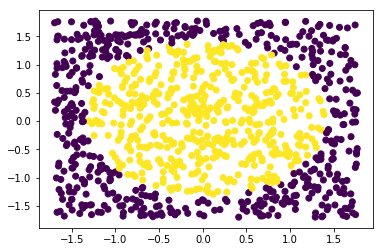

In [37]:
data = torch.FloatTensor(1000,2).uniform_(0, 1) - 0.5
distance = torch.sqrt(torch.pow(data[:, 0], 2) + torch.pow(data[:,1],2)).view(-1,1)
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 1 if x < radius else  -1)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  -1)

target = torch.cat((inside, outside),1)


data = (data - data.mean())/ data.std()
plt.scatter(data[:,0], data[:,1], c=inside.squeeze())
plt.show()

In [40]:
lr =  1e-2
mini_batch_size = 200
nb_epochs = 1000
modules = [Linear(2, 25), Relu(),Linear(25, 25),Relu(),Linear(25, 25),Relu(),Linear(25, 2), Tanh()]
model = Sequential(modules)

train_input, train_target, test_input, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]

train_errors_list, test_errors_list = train_model(model, train_input, train_target, test_input, \
                                                          test_target, nb_epochs, lr, mini_batch_size)

0/1000: train_loss: 4.13 train_error 48.25% test_error 50.50%
1/1000: train_loss: 4.12 train_error 48.25% test_error 50.50%
2/1000: train_loss: 4.10 train_error 48.25% test_error 50.50%
3/1000: train_loss: 4.09 train_error 48.25% test_error 50.50%
4/1000: train_loss: 4.08 train_error 48.25% test_error 50.50%
5/1000: train_loss: 4.07 train_error 48.25% test_error 50.50%
6/1000: train_loss: 4.06 train_error 48.25% test_error 50.50%
7/1000: train_loss: 4.06 train_error 48.25% test_error 50.50%
8/1000: train_loss: 4.05 train_error 48.25% test_error 50.50%
9/1000: train_loss: 4.04 train_error 48.25% test_error 50.50%
10/1000: train_loss: 4.03 train_error 48.38% test_error 50.50%
11/1000: train_loss: 4.03 train_error 48.38% test_error 50.50%
12/1000: train_loss: 4.02 train_error 48.50% test_error 50.50%
13/1000: train_loss: 4.02 train_error 48.50% test_error 50.50%
14/1000: train_loss: 4.01 train_error 48.62% test_error 50.50%
15/1000: train_loss: 4.00 train_error 48.75% test_error 50.50%
16

158/1000: train_loss: 2.26 train_error 6.88% test_error 12.00%
159/1000: train_loss: 2.23 train_error 6.75% test_error 11.50%
160/1000: train_loss: 2.20 train_error 6.50% test_error 11.50%
161/1000: train_loss: 2.17 train_error 6.38% test_error 11.50%
162/1000: train_loss: 2.13 train_error 6.38% test_error 11.50%
163/1000: train_loss: 2.10 train_error 6.38% test_error 11.00%
164/1000: train_loss: 2.07 train_error 6.25% test_error 11.50%
165/1000: train_loss: 2.04 train_error 6.12% test_error 11.00%
166/1000: train_loss: 2.01 train_error 6.12% test_error 10.50%
167/1000: train_loss: 1.98 train_error 6.12% test_error 10.50%
168/1000: train_loss: 1.95 train_error 6.00% test_error 10.50%
169/1000: train_loss: 1.92 train_error 6.00% test_error 10.50%
170/1000: train_loss: 1.89 train_error 5.75% test_error 10.50%
171/1000: train_loss: 1.86 train_error 5.75% test_error 10.50%
172/1000: train_loss: 1.83 train_error 5.75% test_error 10.00%
173/1000: train_loss: 1.81 train_error 5.50% test_error

323/1000: train_loss: 0.48 train_error 1.62% test_error 1.50%
324/1000: train_loss: 0.48 train_error 1.62% test_error 1.50%
325/1000: train_loss: 0.47 train_error 1.62% test_error 1.50%
326/1000: train_loss: 0.47 train_error 1.50% test_error 1.50%
327/1000: train_loss: 0.47 train_error 1.50% test_error 1.50%
328/1000: train_loss: 0.47 train_error 1.38% test_error 1.50%
329/1000: train_loss: 0.47 train_error 1.38% test_error 1.50%
330/1000: train_loss: 0.46 train_error 1.38% test_error 1.50%
331/1000: train_loss: 0.46 train_error 1.38% test_error 1.50%
332/1000: train_loss: 0.46 train_error 1.38% test_error 1.50%
333/1000: train_loss: 0.46 train_error 1.38% test_error 1.50%
334/1000: train_loss: 0.46 train_error 1.38% test_error 1.50%
335/1000: train_loss: 0.45 train_error 1.38% test_error 1.50%
336/1000: train_loss: 0.45 train_error 1.38% test_error 1.50%
337/1000: train_loss: 0.45 train_error 1.38% test_error 1.50%
338/1000: train_loss: 0.45 train_error 1.38% test_error 1.50%
339/1000

490/1000: train_loss: 0.27 train_error 0.62% test_error 1.50%
491/1000: train_loss: 0.27 train_error 0.62% test_error 1.50%
492/1000: train_loss: 0.27 train_error 0.62% test_error 1.50%
493/1000: train_loss: 0.27 train_error 0.62% test_error 1.50%
494/1000: train_loss: 0.27 train_error 0.62% test_error 1.50%
495/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
496/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
497/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
498/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
499/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
500/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
501/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
502/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
503/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
504/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
505/1000: train_loss: 0.26 train_error 0.62% test_error 1.50%
506/1000

652/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
653/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
654/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
655/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
656/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
657/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
658/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
659/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
660/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
661/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
662/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
663/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
664/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
665/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
666/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
667/1000: train_loss: 0.18 train_error 0.25% test_error 1.00%
668/1000

816/1000: train_loss: 0.14 train_error 0.12% test_error 1.00%
817/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
818/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
819/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
820/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
821/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
822/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
823/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
824/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
825/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
826/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
827/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
828/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
829/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
830/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
831/1000: train_loss: 0.13 train_error 0.12% test_error 1.00%
832/1000

986/1000: train_loss: 0.11 train_error 0.00% test_error 1.00%
987/1000: train_loss: 0.11 train_error 0.00% test_error 1.00%
988/1000: train_loss: 0.11 train_error 0.00% test_error 1.00%
989/1000: train_loss: 0.11 train_error 0.00% test_error 1.00%
990/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
991/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
992/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
993/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
994/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
995/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
996/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
997/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
998/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%
999/1000: train_loss: 0.10 train_error 0.00% test_error 1.00%


## Plot Chart

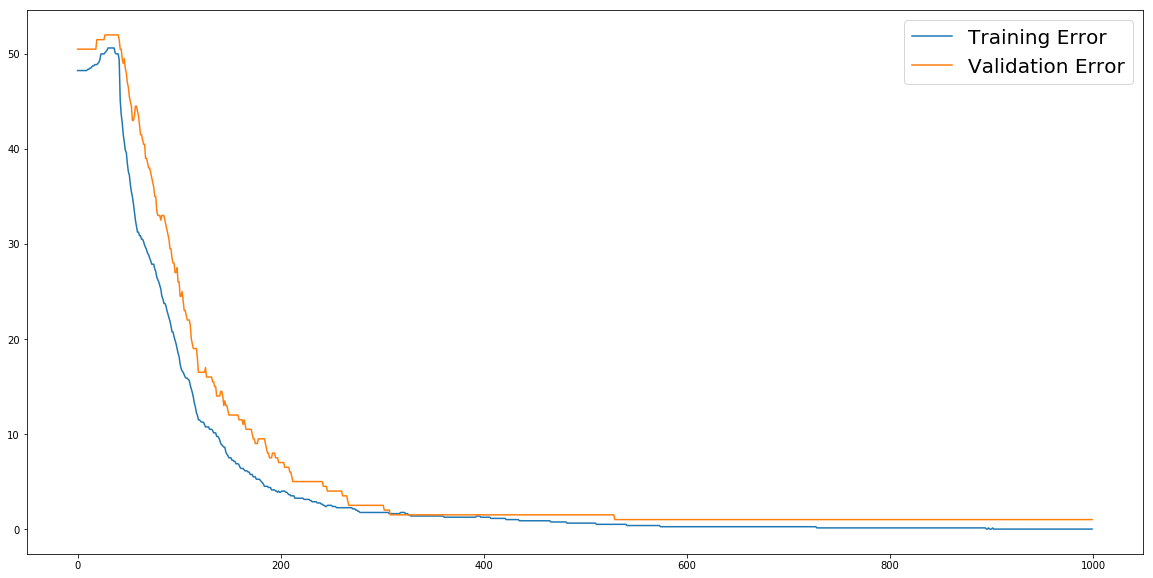

In [47]:
x_axis = range(0, 1000)

plt.figure(figsize=(20,10))
plt.plot(train_errors_list, label='Training Error')
plt.plot(test_errors_list, label='Validation Error')
plt.legend(loc='upper right', prop={'size': 20})
plt.show()